# Elevation Pipeline
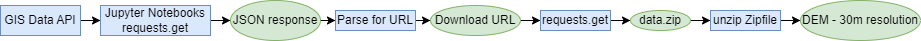

## Import Statements

In [1]:
#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'

#Fixing error in arcgis notebooks, wrong locale wouldn't let us import pandas
import locale
locale.setlocale(locale.LC_ALL, '')

import requests
import os
import zipfile
import shutil
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import arcpy

## Download Elevation Data

In [2]:
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath)
os.chdir(file_path)
#absolute Path for geodatabase
file_path_db = file_path + '\\MN_Geo_Data\\elev_30m_digital_elevation_model.gdb'
arcpy.env.workspace = file_path_db
#URL of API for elevation data
json_url = "https://gisdata.mn.gov/api/3/action/package_show?id=elev-30m-digital-elevation-model"

#GET request to get the JSON data from API
response = requests.get(json_url)

#check if the request was successful
if response.status_code == 200:
    #parse the JSON data from the response
    json_data = response.json()
    
    #API gives new URL to directly download the data
    Mn_Geodataurl = json_data['result']['resources'][1]['url']
    
    #print URL that we are directly downloading data from
    print(f"Target URL: {Mn_Geodataurl}")
else:
    print(f"Failed to fetch JSON data. Status code: {response.status_code}")

#get the current working directory
current_directory = os.getcwd()
#path to downlaod zip file
Mn_GeoName = os.path.join(current_directory, "MN_data.zip")

#getting URL and response is used for download
Mn_Georesult = requests.get(Mn_Geodataurl, stream=True)

#define the folder where the data will be extracted
Mn_Geofolder_new = os.path.join(current_directory, "MN_Geo_Data")
if not os.path.exists(Mn_Geofolder_new):
    os.mkdir(Mn_Geofolder_new)

#save the downloaded ZIP file and extract its contents
with open(Mn_GeoName, 'wb') as file:
    shutil.copyfileobj(Mn_Georesult.raw, file)
#open zip to read
with zipfile.ZipFile(Mn_GeoName, 'r') as zip_Mn_Geo:
    #extract all contents in zip
    zip_Mn_Geo.extractall(Mn_Geofolder_new)
#opening current ArcGIS project
aprx = arcpy.mp.ArcGISProject("CURRENT")
#add the layer file to the current map
map_obj = aprx.activeMap    
map_obj.addDataFromPath(Mn_Geofolder_new + r'\Digital Elevation Model - 30m Resolution.lyr')

Target URL: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/elev_30m_digital_elevation_model/fgdb_elev_30m_digital_elevation_model.zip


## Download Minnesota Boundary
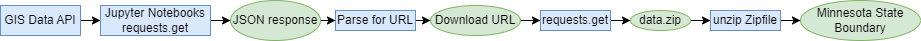

In [3]:
#location and name of downloaded zip file
current_directory = os.getcwd()
#path for downloaded zip
Mn_GeoName = os.path.join(current_directory, "MN_shape_data.zip")
#URL of API for minnesota state boundary
json_url = "https://gisdata.mn.gov/api/3/action/package_show?id=bdry-state-of-minnesota"

#perform the GET request to fetch the JSON data from the API
response = requests.get(json_url)

#check if the request was successful
if response.status_code == 200:
    #parse the JSON data from the response
    json_data = response.json()
    
    #the API gives us a new URL to directly download the data
    Mn_Geodataurl = json_data['result']['resources'][1]['url']
    
     #print the URL of the data that we are directly downloading from, provided by the API
    print(f"Target URL: {Mn_Geodataurl}")
else:
    print(f"Failed to fetch JSON data. Status code: {response.status_code}")
#getting URL and response is used for download
Mn_Georesult = requests.get(Mn_Geodataurl, stream=True)

#folder path for data extraction
Mn_Geofolder_new = os.path.join(current_directory, "MN_Shape_Data")
#if folder does not exist create folder
if not os.path.exists(Mn_Geofolder_new):
    os.mkdir(Mn_Geofolder_new)
#save zip and extract contents/ in write mode
with open(Mn_GeoName, 'wb') as file:
    shutil.copyfileobj(Mn_Georesult.raw, file)
#read in folder
with zipfile.ZipFile(Mn_GeoName, 'r') as zip_Mn_Geo:
    zip_Mn_Geo.extractall(Mn_Geofolder_new)
    
#opens current project
aprx = arcpy.mp.ArcGISProject("CURRENT")
#add the layer file to the current map
map_obj = aprx.activeMap   
#add the specified layer file to map
map_obj.addDataFromPath(Mn_Geofolder_new + r'\Minnesota State Boundary.lyr')

Target URL: https://resources.gisdata.mn.gov/pub/gdrs/data/pub/us_mn_state_dnr/bdry_state_of_minnesota/fgdb_bdry_state_of_minnesota.zip


## Quality Assurance Quality Pipeline
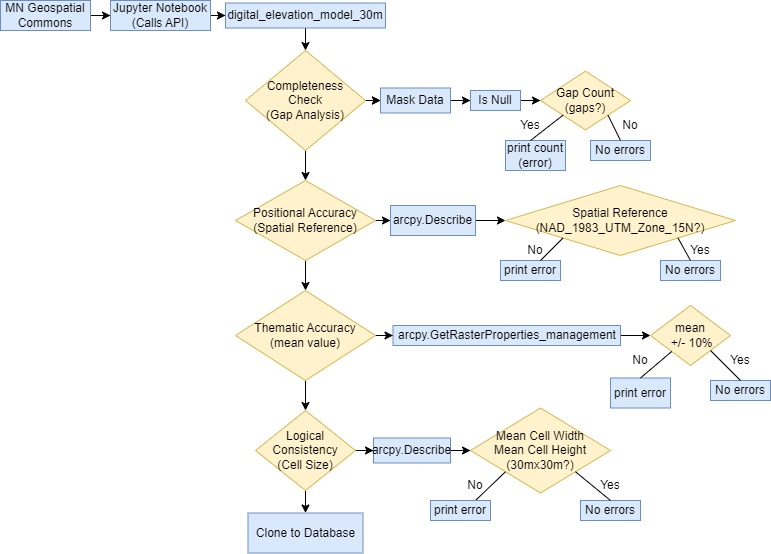

In [4]:
#thematic Accuracy: name of the raster dataset within geodatabase
raster_dataset_name = 'digital_elevation_model_30m'

#create a raster object by referencing the dataset
raster = arcpy.Raster(raster_dataset_name)

#mean elevation
mean_elevation_result = arcpy.GetRasterProperties_management(raster, 'MEAN')
mean_elevation = float(mean_elevation_result.getOutput(0))

#print the mean elevation of dataset
print("Mean elevation of the raster dataset:", mean_elevation)

#this is a +/- 10% of the mean
min_acceptable_elevation = 1080
max_acceptable_elevation = 1320

if min_acceptable_elevation <= mean_elevation <= max_acceptable_elevation:
    print("Data is good")
else:
    print("Data is not good")

Mean elevation of the raster dataset: 1217.65105684861
Data is good


In [5]:
#completeness:path to Minnesota boundary shapefile
minnesota_boundary_path = r"../../MN_Shape_Data/bdry_state_of_minnesota.gdb/state_of_minnesota"
#path to raster dataset
raster_dataset_path = "digital_elevation_model_30m"
#convert the Minnesota boundary to a raster
minnesota_mask_raster = "minnesota_mask"

arcpy.conversion.PolygonToRaster(
    in_features=minnesota_boundary_path,
    value_field="OBJECTID",
    out_rasterdataset=minnesota_mask_raster,
    cell_assignment="MAXIMUM_AREA",
    priority_field="NONE",
    cellsize=raster_dataset_path,
    build_rat="BUILD"
)

#set NoData for areas outside Minnesota
minnesota_mask_raster_nodata = arcpy.ia.SetNull(minnesota_mask_raster, 1, "VALUE <> 1")
#apply the mask to dataset
raster_with_mask = "raster_mask"
arcpy.env.mask = minnesota_mask_raster_nodata
#create copy with mask applied
arcpy.CopyRaster_management(raster_dataset_path, raster_with_mask)

<Result 'C:\\Users\\Track\\OneDrive\\Documents\\ArcGIS\\Projects\\ArcIILab2\\MN_Geo_Data\\elev_30m_digital_elevation_model.gdb\\raster_mask'>

In [6]:
#assigns name of the raster with mask applied
elevation_raster = raster_with_mask
#checks for gaps in elevation data
gap_analysis = arcpy.sa.IsNull(elevation_raster)
#count the number of gaps in the elevation data
gap_count = arcpy.GetCount_management(gap_analysis)
#check if there are any gaps in the elevation data
if int(gap_count.getOutput(0)) > 0:
    print(gap_count.getOutput(0))
    print("Elevation data contains gaps.")
else:
    print("Elevation data is complete.")

2
Elevation data contains gaps.


In [7]:
#positional Accuracy:Path to your file
tif_file = "digital_elevation_model_30m"

#create a Describe object to get the spatial reference
desc = arcpy.Describe(tif_file)

#get the spatial reference
spatial_ref = desc.spatialReference

#print out the spatial reference
print("Spatial Reference Name: {}".format(spatial_ref.name))

#check if the spatial reference name is "NAD_1983_UTM_Zone_15N"
if spatial_ref.name == "NAD_1983_UTM_Zone_15N":
    print("Data is good")
else:
    print("Data is bad")


Spatial Reference Name: NAD_1983_UTM_Zone_15N
Data is good


In [8]:
#logical Consistency (data structure)-- Landsat
#path to your elevation raster dataset
nlcd_file = "digital_elevation_model_30m"

#create a Describe object to get properties of the dataset
desc = arcpy.Describe(nlcd_file)

#get the cell size
cell_width = desc.meanCellWidth
cell_height = desc.meanCellHeight

#print the cell size
print("Cell Size - Width: {} meters, Height: {} meters".format(cell_width, cell_height))

# Check if the cell size is 30 by 30 meters
if cell_width == 30 and cell_height == 30:
    print("Data is good")
else:
    print("Data is bad")


Cell Size - Width: 30.0 meters, Height: 30.0 meters
Data is good
